In [1]:
# !pip install spacy nltk wordcloud
!python -m spacy download pt_core_news_sm

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import seaborn as sns
import spacy
from wordcloud import WordCloud

nltk.download('stopwords')

# Oculta warnings do notebook
# import warnings
# warnings.filterwarnings('ignore')

# Configurações de visualização
pd.set_option('display.max_columns', 100)
pd.options.display.float_format = '{:,.2f}'.format

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 12.0 MB/s eta 0:00:00m eta 0:00:010:00:01
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


[nltk_data] Downloading package stopwords to /home/paim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
dataset_path = 'datasets/scrapped/'
df = pd.read_csv(f"{dataset_path}ErikakHilton-2022-10-01-2022-11-01-2023-02-16T19:31:01.224464.csv", sep=';')
print(df.shape)
df.info()

(22505, 49)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22505 entries, 0 to 22504
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   url                       22505 non-null  object 
 1   date                      22505 non-null  object 
 2   rawContent                22505 non-null  object 
 3   renderedContent           22505 non-null  object 
 4   id                        22505 non-null  int64  
 5   user                      22505 non-null  object 
 6   replyCount                22505 non-null  int64  
 7   retweetCount              22505 non-null  int64  
 8   likeCount                 22505 non-null  int64  
 9   quoteCount                22505 non-null  int64  
 10  conversationId            22505 non-null  int64  
 11  lang                      22505 non-null  object 
 12  source                    0 non-null      float64
 13  sourceUrl                 0 non-null      float64

/tmp/ipykernel_5702/1434453689.py:2: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"{dataset_path}ErikakHilton-2022-10-01-2022-11-01-2023-02-16T19:31:01.224464.csv", sep=';')


In [3]:
drop_columns = [
    'renderedContent',  # Possui praticamente o mesmo que a rawContent
    'source', 'sourceUrl', 'sourceLabel', 'links', 'retweetedTweet',  # Muitos nulos
    'quotedTweet', 'coordinates', 'place', 'cashtags', 'card',   # Muitos nulos
    'viewCount', 'vibe', 'user_descriptionLinks', 'user_label',  # Muitos nulos
]
df = df.drop(drop_columns, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22505 entries, 0 to 22504
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   url                       22505 non-null  object 
 1   date                      22505 non-null  object 
 2   rawContent                22505 non-null  object 
 3   id                        22505 non-null  int64  
 4   user                      22505 non-null  object 
 5   replyCount                22505 non-null  int64  
 6   retweetCount              22505 non-null  int64  
 7   likeCount                 22505 non-null  int64  
 8   quoteCount                22505 non-null  int64  
 9   conversationId            22505 non-null  int64  
 10  lang                      22505 non-null  object 
 11  media                     3282 non-null   object 
 12  inReplyToTweetId          21118 non-null  float64
 13  inReplyToUser             21118 non-null  object 
 14  mentio

In [4]:
# Checando e removendo linhas duplicadas
# Não sei ao certo pq isso aconteceu (pode ser um bug no scrapper ao pegar muitos dados), mas é fácil de tratar
duplicated_indexes = df[df.duplicated()].index
df = df.drop(duplicated_indexes)

In [5]:
# Separando tweets da Erika em uma serie
tweets_op = df[df.user == 'https://twitter.com/ErikakHilton'].rawContent

In [6]:
spc_pt = spacy.load("pt_core_news_sm")

#Remover stopwords
stopwords = nltk.corpus.stopwords.words('portuguese')

#Adicionando stopwords que não estão na lista do nltk 
stopwords.append("'")
stopwords.append("pra")
stopwords.append("tá")

In [7]:
def tokenize_tweet(tweet):
    # Remove non-letter characters and convert to lower case
    tweet_letters =  re.findall(r'\b[A-zÀ-úü://.]+\b', tweet.lower())

    meaningful_words = [w for w in tweet_letters if w not in stopwords]
    meaningful_words_string = " ".join(meaningful_words)

    #Instanciando o objeto spacy
    spc_letters =  spc_pt(meaningful_words_string)

    #Lemmização 
    tokens = [token.lemma_ if token.pos_ == 'VERB' else str(token) for token in spc_letters]

    #problemas com verbo ir
    ir = ['vou', 'vais', 'vai', 'vamos', 'ides', 'vão']
    tokens = ['ir' if token in ir else str(token) for token in tokens]

    return tokens 

print(tweets_op[0])
tokenize_tweet(tweets_op[0])

Ao longo do dia estou recebendo denúncias, inclusive de pessoas presas há mais de 16h na estrada, sem água e sem comida, pelos bloqueios ilegais dos caminhoneiros.

Por isso, enviei requerimento para que a PRF nos dê informações sobre as dimensões dos atos e providencias tomadas. https://t.co/g0zRPmBLLX


['longo',
 'dia',
 'receber',
 'denúncias',
 'inclusive',
 'pessoas',
 'presas',
 'estrada',
 'água',
 'comer',
 'bloqueios',
 'ilegais',
 'caminhoneiros',
 'enviei',
 'requerimento',
 'prf',
 'dê',
 'informações',
 'sobre',
 'dimensões',
 'atos',
 'providencias',
 'tomar',
 'https://t.co/']

In [8]:
tweet_tokens = tweets_op.apply(tokenize_tweet)
tokens_list = tweet_tokens.sum()

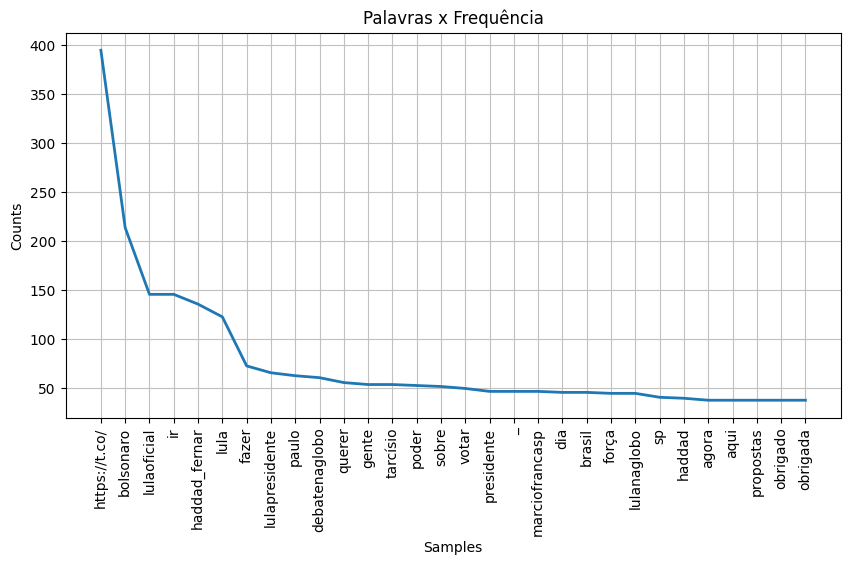

<AxesSubplot: title={'center': 'Palavras x Frequência'}, xlabel='Samples', ylabel='Counts'>

In [9]:
plt.figure(figsize=(10,5))
fd = nltk.FreqDist(tokens_list)
fd.plot(30, title = "Palavras x Frequência", cumulative=False)

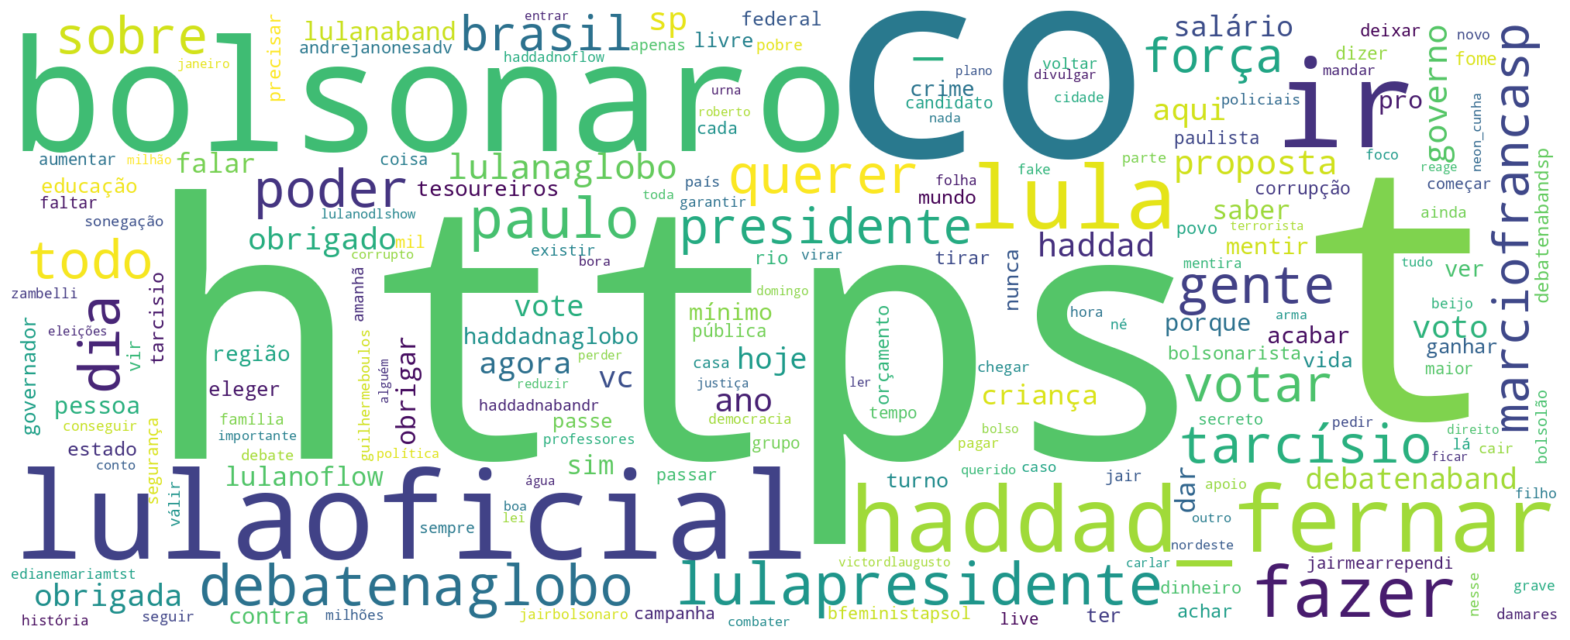

In [10]:
text = " ".join(tokens_list)
wordcloud = WordCloud(
    background_color="white",
    width=2000, height=800, 
    collocations=False
).generate(text)

fig = plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()